# Basic Model Steps
- Take clustered data
- Chunk satellite image
- For each image, associate random socioeconomic data
- Treat as direct label

This notebook is a spike to create the chunked satellite data

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import plotting_extent
import rioxarray as rxr
import earthpy.spatial as es
import earthpy.plot as ep


In [2]:
# Have to add some conversion logic because plaintext geometry is not understood in CSV
path = '../outputs/clustered-data.csv'
df = pd.read_csv(path)
gdf = gpd.GeoDataFrame(
    df.loc[:, [c for c in df.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(df["geometry"]),
    crs="EPSG:4326",
)
gdf.sort_values(by='service_index', ascending=False)
gdf

,ward_id,municipality,district,service_index,geometry
0,79800001,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.169350,"POLYGON ((27.85070 -26.47969, 27.85068 -26.481..."
1,79800002,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.658822,"POLYGON ((27.88070 -26.49284, 27.88087 -26.493..."
2,79800003,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.245713,"POLYGON ((27.87042 -26.46787, 27.87059 -26.470..."
3,79800004,City of Johannesburg Metropolitan Municipality,City of Johannesburg,8.594442,"POLYGON ((27.86958 -26.44910, 27.86958 -26.449..."
4,79800005,City of Johannesburg Metropolitan Municipality,City of Johannesburg,8.745830,"POLYGON ((27.81010 -26.42435, 27.81439 -26.425..."
...,...,...,...,...,...
130,79800131,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.049961,"POLYGON ((27.87290 -26.48950, 27.87296 -26.489..."
131,79800132,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.765982,"POLYGON ((28.08813 -25.98413, 28.09191 -25.988..."
132,79800133,City of Johannesburg Metropolitan Municipality,City of Johannesburg,7.922886,"POLYGON ((28.19591 -25.98487, 28.19595 -25.985..."
133,79800134,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.440186,"POLYGON ((27.96747 -26.01655, 27.96736 -26.016..."


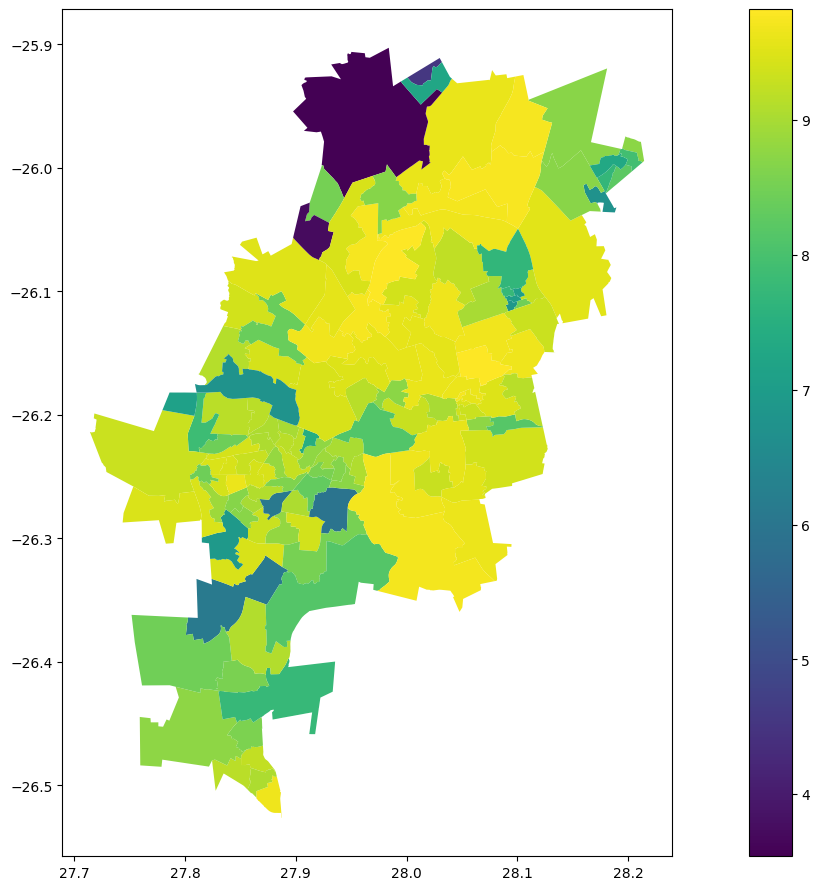

In [3]:
figsize = (20, 11)

gdf.plot('service_index', legend=True, figsize=figsize);

In [4]:
image_file = '../data/images/20230318_075512_29_249d_3B_AnalyticMS_SR_8b.tif'
raster_crs = es.crs_check(image_file)

print(raster_crs)

# Transforming ward boundaries to raster data crs which is necessary so that coordinate data overlaps
gdf = gdf.to_crs(raster_crs)


EPSG:32735


In [34]:
from rasterio.mask import mask
from rasterio.plot import show

from pathlib import Path
output_dir = '../outputs/chunked-satellite-images'
Path(output_dir).mkdir(parents=True, exist_ok=True)

# load the raster, mask it by the polygon and crop it
with rasterio.open(image_file) as src:
    for index, record in gdf.iterrows():
        geom = [record['geometry']]
        try:
            out_profile = src.profile.copy()
            out_image, out_transform = mask(src, geom, crop=True)

            out_profile.update({"driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform})
            out_ward = record['ward_id']

            with rasterio.open(f"{output_dir}/{out_ward}.tif", "w", **out_profile) as dest:
                dest.write(out_image)
            print(f"SUCCESS: Ward{out_ward}")
            print(geom)
        except Exception as e:
            print('Failed to mask', e)
            continue



Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
Failed to mask Input shapes do not overlap raster.
SUCCESS: Ward79800019
[<POLYGON ((588873.66 7094244.966, 588816.332 7094178.408, 5

# Notes
- Masking the satellite image with the shapefile ignores regions that may be missing
    - For example, the first ward that matches the image location is 79800019. However, this is a black region in the satellite image and therefore does not actually have anything in it. This is why the outtput for this ward is completely black.
    - I will need to get around this - maybe look at https://rasterio.readthedocs.io/en/stable/topics/masks.html or https://carpentries-incubator.github.io/geospatial-python/aio/index.html#dealing-with-missing-data
- I will need to find a way to get the right satellite images for each ward still.
- I ran into an issue with the satellite image only being masked in a single channel
- May be valuable to look at a technique like described in this comment https://forums.fast.ai/t/from-shapefile-satellite-data-to-supervised-classification/45412/7,
    - Where the mask is not the input alone but rather an additional input channel. It's useful for the model to look at surrounding context as well


In [35]:
print(out_profile)
print(out_ward)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 12371, 'height': 8909, 'count': 8, 'crs': CRS.from_epsg(32735), 'transform': Affine(3.0, 0.0, 588822.0,
       0.0, -3.0, 7120602.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}
79800134


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1706, 'height': 2719, 'count': 8, 'crs': CRS.from_epsg(32735), 'transform': Affine(3.0, 0.0, 592122.0,
       0.0, -3.0, 7120602.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


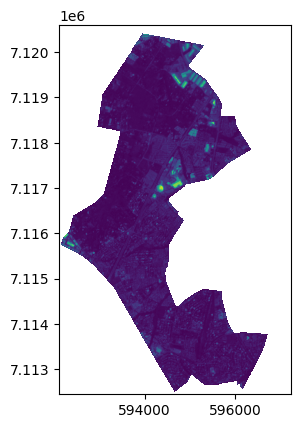

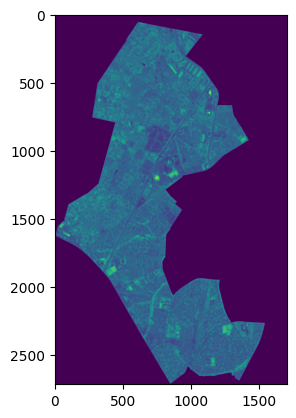

In [41]:
with rasterio.open(f"{output_dir}/79800134.tif") as src:
    print(src.profile)
    show(src)
    band1 = src.read(8)
    show(band1)